# Importing Libraries

In [48]:
#Utility Files are taken from Coursera RL Specilization from University of Alberta

import numpy as np
import matplotlib.pyplot as plt
import rl_glue
from rl_glue import RLGlue
import main_agent
import ten_arm_env
import test_env
import time
from tqdm import tqdm

## Greedy Agent

In [49]:
def argmax(Q_values):
    """
    Params: Takes array of Estimated Q values
    Returns
    action -- Returns the index(or action) with maximum Q value.
    """
    max_val = -float('inf') 
    indices = []
    for i in range(len(Q_values)):
        if(Q_values[i] > max_val):
            indices.clear()
            max_val,indices = Q_values[i], [i]
        
        elif(Q_values[i] == max_val):
            indices.append(i)
    
    #Select randomly if there are multiple actions with maximum value
    action = np.random.choice(indices)
    
    return action
    
    

In [50]:
# Test Script From Coursera RL Specialization
# Testing argmax implementation 
test_array = [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
assert argmax(test_array) == 8, "Check your argmax implementation returns the index of the largest value"

test_array = [1, 0, 0, 1]
total = 0
for i in range(100):
    total += argmax(test_array)

np.save("argmax_test", total)

assert total > 0, "Make sure your argmax implementation randomly choooses among the largest values. Make sure you are not setting a random seed (do not use np.random.seed)"
assert total != 300, "Make sure your argmax implementation randomly choooses among the largest values."


In [51]:
class GreedyAgent(main_agent.Agent):
    
    def agent_step(self, reward, observation):
        """ 
        Takes reward and observation from last time step and selects action for the present time step.
        Arguments:
        reward -- float, the reward the agent received from the environment after taking the last action.
        observation -- float, the observed state the agent is in.
        Returns:
        current_action -- int, the action chosen by the agent at the current time step.
        """
        
        # Updating Q_value according to reward from last action
        self.last_action = int(self.last_action)
        self.arm_count[self.last_action] += 1
        step_size = 1/self.arm_count[self.last_action]
        self.q_values[self.last_action] += step_size*(reward - self.q_values[self.last_action])
        
        # Select current action greedily 
        current_action = argmax(self.q_values)
        self.last_action = current_action
        
        return current_action

In [52]:
# Test Script for Greedy Agent Code
greedy_agent = GreedyAgent()
greedy_agent.q_values = [0, 0, 0, 0, 0]
greedy_agent.arm_count = [0, 0, 0, 0, 0]
greedy_agent.last_action = 1
action = greedy_agent.agent_step(1, 0)
np.save("greedy_test", greedy_agent.q_values)
print("Output:")
print(greedy_agent.q_values)
print("Expected Output:")
print([0, 1, 0, 0, 0])

assert action == 1, "Check that you are using argmax to choose the action with the highest value."
assert greedy_agent.q_values == [0, 1, 0, 0, 0], "Check that you are updating q_values correctly."

Output:
[0, 1.0, 0, 0, 0]
Expected Output:
[0, 1, 0, 0, 0]


100%|██████████| 200/200 [00:03<00:00, 54.97it/s]


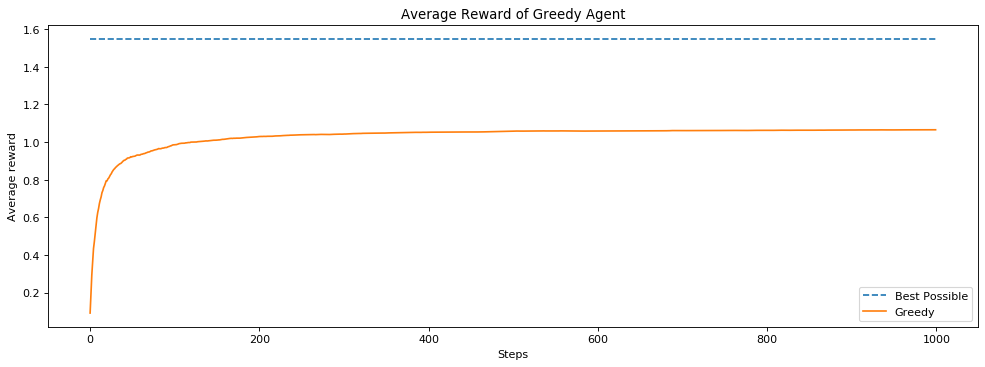

In [53]:
# Plot Greedy Result
num_runs = 200                    # The number of times we run the experiment
num_steps = 1000                  # The number of steps each experiment is run for
env = ten_arm_env.Environment     # We the environment to use
agent = GreedyAgent               # We choose what agent we want to use
agent_info = {"num_actions": 10}  # Pass the agent the information it needs; 
                                  # here it just needs the number of actions (number of arms).
env_info = {}                     # Pass the environment the information it needs; in this case, it is nothing.

all_averages = []

for j in tqdm(range(num_runs)):           # tqdm is what creates the progress bar below once the code is run
    rl_glue = RLGlue(env, agent)          # Creates a new RLGlue experiment with the env and agent we chose above
    rl_glue.rl_init(agent_info, env_info) # Pass RLGlue what it needs to initialize the agent and environment
    rl_glue.rl_start()                    # Start the experiment

    #scores = [0]
    averages = []
    total_reward = 0
    for i in range(num_steps):
        reward, _, action, _ = rl_glue.rl_step() # The environment and agent take a step and return
                                                 # the reward, and action taken.
        #scores.append(scores[-1] + reward)
        total_reward += reward
        averages.append(total_reward / (i + 1))
    all_averages.append(averages)

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")
plt.plot(np.mean(all_averages, axis=0))
plt.legend(["Best Possible", "Greedy"])
plt.title("Average Reward of Greedy Agent")
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()
greedy_scores = np.mean(all_averages, axis=0)
np.save("greedy_scores", greedy_scores)

## Epsilon Greedy

In [54]:
class EpsilonGreedyAgent(main_agent.Agent):
    def agent_step(self, reward, observation):
        """ 
        Takes reward and observation from last time step and selects action for the present time step.
        Arguments:
        reward -- float, the reward the agent received from the environment after taking the last action.
        observation -- float, the observed state the agent is in.
        Returns:
        current_action -- int, the action chosen by the agent at the current time step.
        """
        
        # Updating Q_value according to reward from last action
        self.last_action = int(self.last_action)
        self.arm_count[self.last_action] += 1
        step_size = 1/self.arm_count[self.last_action]
        self.q_values[self.last_action] += step_size*(reward - self.q_values[self.last_action])
        
        # Select current action greedily 
        current_action = argmax(self.q_values)
        self.last_action = current_action
        
        # find current
        probability = np.random.random()
        if probability < self.epsilon:
            current_action = np.random.randint(self.num_actions)
        else:
            current_action = argmax(self.q_values)
        
        self.last_action = current_action
        
        return current_action
        

100%|██████████| 200/200 [00:06<00:00, 33.33it/s]


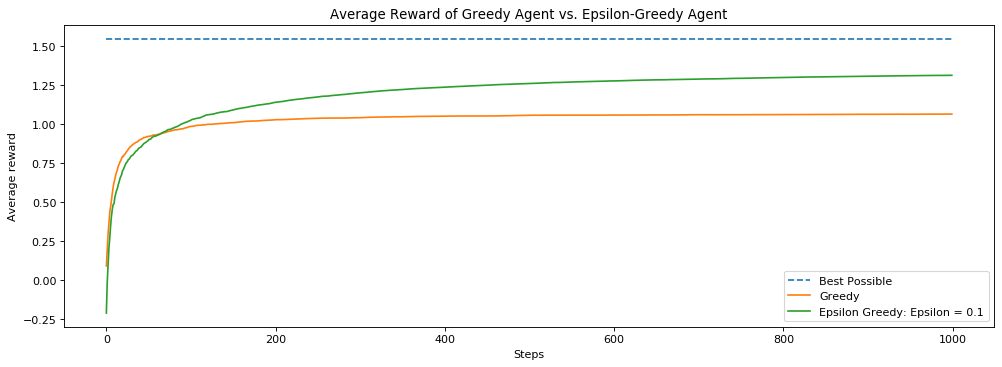

In [55]:
# Plot Greedy Result
num_runs = 200                    # The number of times we run the experiment
num_steps = 1000                  # The number of steps each experiment is run for
epsilon = 0.1
env = ten_arm_env.Environment     # We the environment to use
agent = EpsilonGreedyAgent               # We choose what agent we want to use
agent_info = {"num_actions": 10, "epsilon": epsilon}  # Pass the agent the information it needs; 
                                  # here it just needs the number of actions (number of arms).
env_info = {}                     # Pass the environment the information it needs; in this case, it is nothing.

all_averages = []

for j in tqdm(range(num_runs)):           # tqdm is what creates the progress bar below once the code is run
    rl_glue = RLGlue(env, agent)          # Creates a new RLGlue experiment with the env and agent we chose above
    rl_glue.rl_init(agent_info, env_info) # Pass RLGlue what it needs to initialize the agent and environment
    rl_glue.rl_start()                    # Start the experiment

    #scores = [0]
    averages = []
    total_reward = 0
    for i in range(num_steps):
        reward, _, action, _ = rl_glue.rl_step() # The environment and agent take a step and return
                                                 # the reward, and action taken.
        #scores.append(scores[-1] + reward)
        total_reward += reward
        averages.append(total_reward / (i + 1))
    all_averages.append(averages)

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")
plt.plot(greedy_scores)
plt.plot(np.mean(all_averages, axis=0))
plt.legend(("Best Possible", "Greedy", "Epsilon Greedy: Epsilon = 0.1"))
plt.title("Average Reward of Greedy Agent vs. Epsilon-Greedy Agent")
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()
#e_greedy = np.mean(all_averages, axis=0)
#np.save("e-greedy", e_greedy)

## Comparing values of epsilons

100%|██████████| 200/200 [00:05<00:00, 36.08it/s]


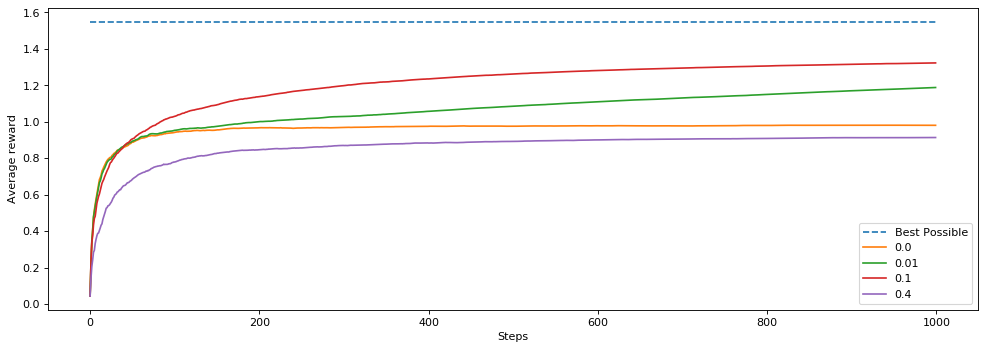

In [57]:
# Experiment code for epsilon-greedy with different values of epsilon
epsilons = [0.0, 0.01, 0.1, 0.4]

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")

num_runs = 200

agent = EpsilonGreedyAgent

for epsilon in epsilons:
    all_averages = []
    
    for run in tqdm(range(num_runs)):
        agent_info = {"num_actions": 10, "epsilon": epsilon}
        env_info = {"random_seed": run}

        rl_glue = RLGlue(env, agent)
        rl_glue.rl_init(agent_info, env_info)
        rl_glue.rl_start()
        
        averages = []
        total_reward = 0
        for i in range(num_steps):
            reward, state, action, is_terminal = rl_glue.rl_step()
            total_reward += reward
            averages.append(total_reward/(i+1))
        
        all_averages.append(averages)
    plt.plot(np.mean(all_averages,axis = 0))
plt.legend(["Best Possible"] + epsilons)
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()


## Effect of Step Sizes

In [ ]:
# Constant Step Size Agent Here 
# Greedy agent here
class EpsilonGreedyAgentConstantStepsize(main_agent.Agent):
    def agent_step(self, reward, observation):
        """
        Takes one step for the agent. It takes in a reward and observation and 
        returns the action the agent chooses at that time step.
        
        Arguments:
        reward -- float, the reward the agent received from the environment after taking the last action.
        observation -- float, the observed state the agent is in. Do not worry about this for this assignment 
        as you will not use it until future lessons.
        Returns:
        current_action -- int, the action chosen by the agent at the current time step.
        """
        
        last_action = int(self.last_action)
        
        self.q_values[last_action] += self.step_size*(reward - self.q_values[last_action])
        
        
        prob = np.random.random()
        if prob < self.epsilon:
            current_action = np.random.randint(self.num_actions)
        else:
            current_action = argmax(self.q_values)
        
        ### END CODE HERE ###
        
        self.last_action = current_action
        
        return current_action